# Strategy Testing

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
class TradingStrategy:
    def __init__(self, ranking_df, stock_folder='data', lookahead_days=10, initial_capital=1000000, buy_n=5, sell_n=5, handling_fee_rate=0.0015):
        self.ranking_df = ranking_df
        self.stock_folder = stock_folder
        self.lookahead_days = lookahead_days
        self.initial_capital = initial_capital
        self.buy_n = buy_n
        self.sell_n = sell_n
        self.handling_fee_rate = handling_fee_rate
        self.stock_prices = self._load_stock_prices()

    def _load_stock_prices(self):
        stock_files = [f for f in os.listdir(self.stock_folder) if f != 'companies.csv']
        stock_data = {}
        for file in stock_files:
            stock = file.split('_')[0]
            file_path = os.path.join(self.stock_folder, file)
            df = pd.read_csv(file_path)
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
            df[f'{self.lookahead_days}d Profit'] = (df['Close'].shift(-self.lookahead_days)-df['Close'])
            df[f'{self.lookahead_days}d Return rate'] = df[f'{self.lookahead_days}d Profit']/df['Close']
            df['Handling fee'] = df['Close']*self.handling_fee_rate + df['Close'].shift(-self.lookahead_days)*self.handling_fee_rate
            stock_data[stock] = df
        return stock_data

    def backtest(self):
        portfolio_value = [self.initial_capital]
        cum_return_rate = [0]

        for _, row in self.ranking_df.iterrows():
            date = row['Date']
            if date not in self.stock_prices['2330'].index:
                continue

            # Get the ranking of this date
            ranking_list = row['Ranking']

            # Determine the stocks to buy and sell
            top_stocks = ranking_list[:self.buy_n]
            bottom_stocks = ranking_list[-self.sell_n:]

            long_position_profit = sum(self.stock_prices[stock].loc[date, f'{self.lookahead_days}d Profit']-self.stock_prices[stock].loc[date, 'Handling fee'] for stock in top_stocks)
            short_position_profit = sum(-self.stock_prices[stock].loc[date, f'{self.lookahead_days}d Profit']-self.stock_prices[stock].loc[date, 'Handling fee'] for stock in bottom_stocks)

            total_profit = (long_position_profit + short_position_profit)*1000
            portfolio_value.append(portfolio_value[-1]+total_profit)

            long_position_return = sum(self.stock_prices[stock].loc[date, f'{self.lookahead_days}d Return rate']-self.handling_fee_rate*2 for stock in top_stocks)
            short_position_return = sum(-self.stock_prices[stock].loc[date, f'{self.lookahead_days}d Return rate']-self.handling_fee_rate*2 for stock in bottom_stocks)

            total_return = long_position_return+short_position_return
            cum_return_rate.append(cum_return_rate[-1]+total_return)

        return portfolio_value, cum_return_rate

## Testing toy data

### Create toy data

In [ ]:
df = pd.read_csv('data/companies.csv')
num_days = 50
dates = pd.date_range(start='2022-01-01', periods=num_days, freq='12D')
data = []
for date in dates:
    shuffled_df = df.sample(frac=1).reset_index(drop=True)
    shuffled_list = shuffled_df['ticker'].astype(str).tolist()
    data.append([date, shuffled_list])

ranking_df = pd.DataFrame(data, columns=['Date', 'Ranking'])
print(ranking_df)

         Date                                            Ranking
0  2022-01-01  [2633, 1301, 2885, 9904, 9910, 2882, 1303, 235...
1  2022-01-13  [2408, 2892, 2308, 2409, 2887, 2317, 1101, 990...
2  2022-01-25  [5871, 9910, 5880, 2615, 6505, 2609, 2884, 235...
3  2022-02-06  [2357, 2303, 2885, 1101, 2912, 2382, 2201, 288...
4  2022-02-18  [2454, 5880, 1303, 9910, 5871, 2354, 2888, 222...
5  2022-03-02  [8454, 2227, 3008, 1402, 2882, 2412, 2633, 666...
6  2022-03-14  [2888, 2454, 2883, 2408, 2308, 2892, 6415, 110...
7  2022-03-26  [6415, 2912, 2883, 2454, 6669, 2884, 2881, 289...
8  2022-04-07  [2382, 2609, 2892, 2327, 6415, 2201, 2633, 371...
9  2022-04-19  [2105, 2633, 1101, 5880, 2887, 2891, 2882, 990...
10 2022-05-01  [1102, 5880, 1303, 9910, 2885, 2881, 2354, 200...
11 2022-05-13  [2890, 2801, 2886, 2227, 8454, 2301, 1102, 650...
12 2022-05-25  [1402, 2474, 4938, 1101, 1102, 2201, 2884, 288...
13 2022-06-06  [2881, 3711, 2884, 6415, 2890, 2303, 5871, 288...
14 2022-06-18  [1402, 233

### Strategy Testing (Buy 5, Sell 5)

In [ ]:
strategy = TradingStrategy(ranking_df)
portfolio_value, cum_return_rate = strategy.backtest()
print(portfolio_value)
print(cum_return_rate)

[1000000, 1097583.8266916275, 1142952.7767295837, 964406.2979593277, 860148.6905059814, 875362.9328670502, 838508.3888368607, 835642.3431544304, 807627.5725188255, 777532.0666351318, 810008.8085808754, 790739.0185332298, 830348.3086719513, 836839.044757843, 902897.1931982042, 858399.6644973756, 795903.1188478471, 769816.3528950216, 871290.8789818288, 862501.6332070829, 880718.4398076535, 933246.9178617002, 946731.0733716489, 952701.940731764, 953616.0873358251, 859491.2928307058, 905787.60938859, 1003641.1629793645, 981770.5006201268, 975974.2276003362, 924386.3101589681, 777027.6420280935, 887321.2733209134, 923979.5540292264, 849943.9222543241]
[0, 0.0190469103500428, 0.25955786284281124, 0.18151283119118028, 0.22427326894094327, 0.17468925487548997, 0.18825848648715898, 0.20766234091303964, 0.1324245867070338, 0.08430691687232729, -0.2223647638448651, -0.22159996775792984, -0.11301273660189459, -0.11768567761077439, -0.10090263753419854, -0.10344103749405728, -0.053199956341641624, 

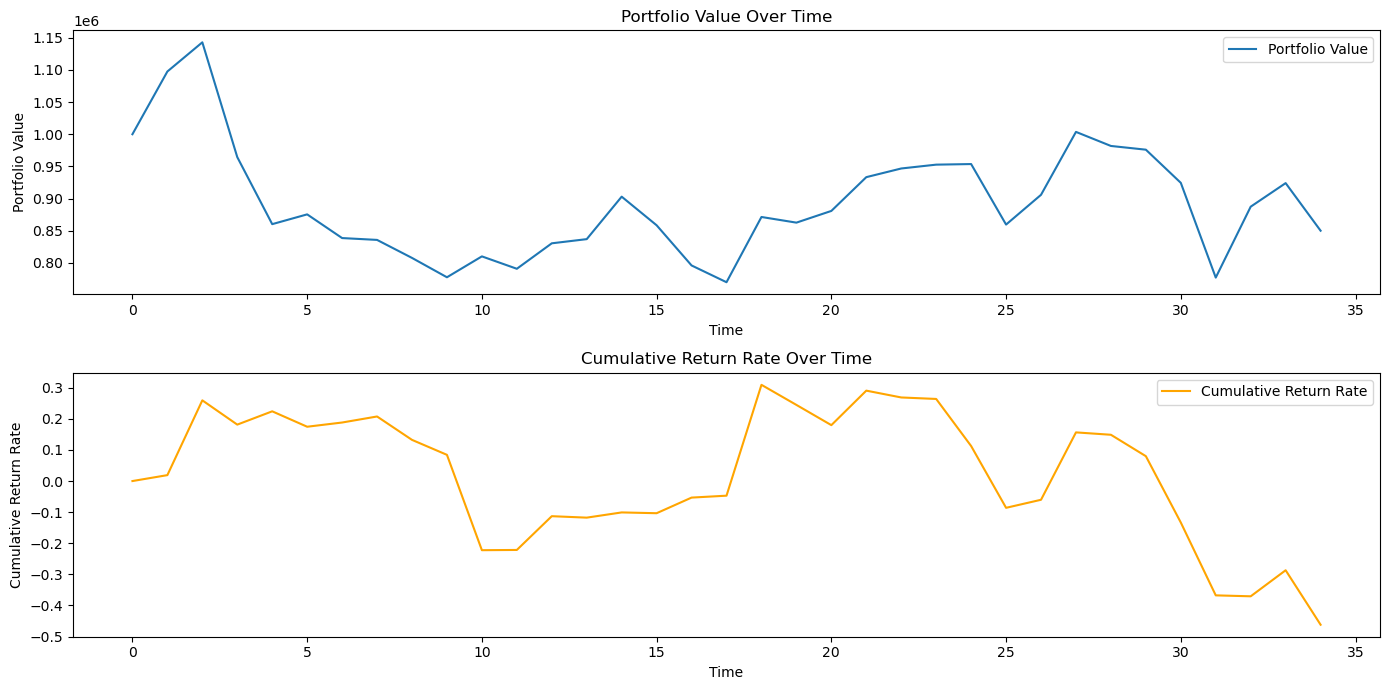

In [ ]:
# Visualize results
plt.figure(figsize=(14, 7))

# Plot portfolio value
plt.subplot(2, 1, 1)
plt.plot(portfolio_value, label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Plot cumulative return rate
plt.subplot(2, 1, 2)
plt.plot(cum_return_rate, label='Cumulative Return Rate', color='orange')
plt.title('Cumulative Return Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Return Rate')
plt.legend()

plt.tight_layout()
plt.show()

### Strategy Testing (Buy 5, Sell 0)

In [ ]:
strategy = TradingStrategy(ranking_df, buy_n=5, sell_n=0)
portfolio_value, cum_return_rate = strategy.backtest()
print(portfolio_value)
print(cum_return_rate)

[1000000, 2016919.9605689049, 1599615.4638757706, 2389574.392747879, 3038923.3174743652, 3149843.4304418564, 3006683.358186245, 3155793.6615810394, 2975515.2854151726, 2326089.5110025406, 3128718.5968704224, 2904994.259010315, 2478356.711081028, 2328069.3154816628, 2680872.641495228, 2579059.285785198, 2676203.9447612762, 2874998.599033594, 1958613.7781898978, 1220717.2939097884, 751187.9538385873, 1251949.9201853282, 847249.965795756, 853773.036005736, 627246.7698066239, 521688.87056183856, 429401.59781241463, 711220.895040751, 793092.9113585954, 449126.9712994103, 145757.11949038523, 225882.74772286433, -329615.1850421427, 78481.47839283955, 444976.69311547297]
[0, 1.496838220640308, -0.5158927888951192, 1.5476095173347126, 3.0632030538003256, 2.27044741678519, 2.4894399678316397, 2.7807871003836935, 1.4520503383568466, -0.6057591622400993, 2.4484711354956543, 3.4364658726863992, 1.2790121119464684, -0.45891415524228174, 0.6621394014555708, 0.08486615002439057, 1.1583957174212551, 2.

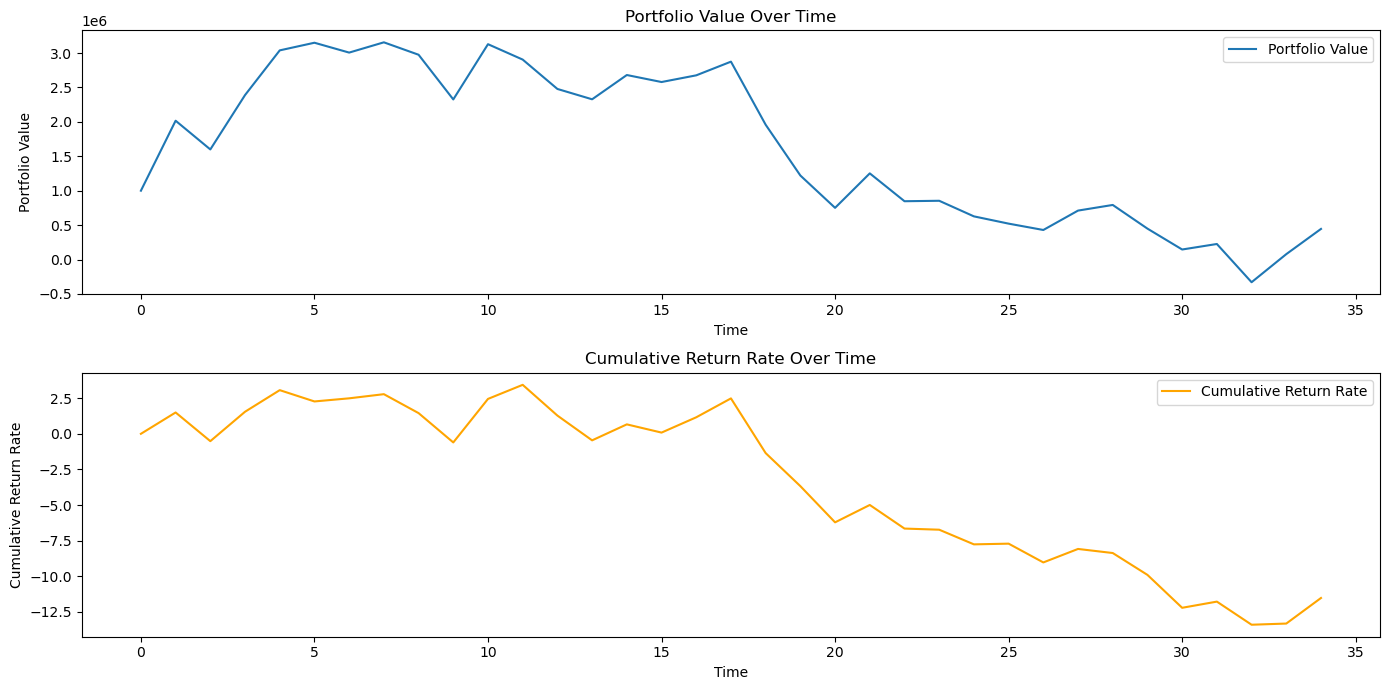

In [ ]:
# Visualize results
plt.figure(figsize=(14, 7))

# Plot portfolio value
plt.subplot(2, 1, 1)
plt.plot(portfolio_value, label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Plot cumulative return rate
plt.subplot(2, 1, 2)
plt.plot(cum_return_rate, label='Cumulative Return Rate', color='orange')
plt.title('Cumulative Return Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Return Rate')
plt.legend()

plt.tight_layout()
plt.show()

## Strategy Backtesting